In [ ]:
#| default_exp 06-metadata-augmented-input-and-trie-for-distilbert-n_bm-50

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os, pandas as pd, warnings, torch, pickle
from tqdm.auto import tqdm
from scipy import stats

from xcai.basics import *
from xcai.models.MMM00X import DBT007, DBT008
from xcai.transform import AugmentMetaInputIdsTfm

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
dump_dir = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/06-metadata-augmented-input-and-trie-for-distilbert-n_bm-50/'

In [ ]:
#| export
fname = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/data/block.pkl'
with open(fname, 'rb') as f: block, test_dset = pickle.load(f)

# Generation

In [ ]:
#| export
mname = f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000'
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0)

Some weights of DBT007 were not initialized from the model checkpoint at /scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000 and are newly initialized: ['loss_fn.o']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
args = XCLearningArguments(
    output_dir=f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K',
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
#| export
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## `meta-augmented trie`

In [ ]:
a_trie = XCTrie.from_block(block, meta=['hlk'])

  0%|          | 0/312330 [00:00<?, ?it/s]

  0%|          | 0/2458399 [00:00<?, ?it/s]

In [ ]:
learn.tbs.trie = a_trie

In [ ]:
learn.tbs.n_bm = learn.args.generation_num_beams = 50

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,13.9,7.6667,5.45,3.18,13.9,12.8276,12.9828,13.4749,8.3367,7.7294,7.9533,8.5796,8.3367,8.3706,8.7535,9.2995,10.3099,11.8286,14.9729,20.2701,24.2323,29.5366,7.0555,1380.2638,1.449,0.046


In [ ]:
pred_fname = f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/predictions/test_lbl_atrie-hlk_n-bm-50_n-smp-2000_seed-50.pth'
os.makedirs(os.path.dirname(pred_fname), exist_ok=True)
torch.save(o, pred_fname)

In [ ]:
o

XCPredictionOutput(pred_idx=tensor([229942,  29816,  45914,  ..., 142001, 253117, 292993]), pred_ptr=tensor([  286,   404,   878,  ...,   204, 25183,   392]), pred_score=tensor([-1.0248, -1.1815, -0.8172,  ..., -0.4384, -0.4637, -0.4913]), metrics={'test_loss': 7.055476665496826, 'test_P@1': 0.139, 'test_P@10': 0.031800000000000224, 'test_P@3': 0.07666666666666666, 'test_P@5': 0.054500000000000354, 'test_N@1': 0.13899999856948853, 'test_N@10': 0.13474920392036438, 'test_N@3': 0.12827645242214203, 'test_N@5': 0.12982787191867828, 'test_PSP@1': 0.08336684690000871, 'test_PSP@10': 0.08579561705091043, 'test_PSP@3': 0.07729367959070517, 'test_PSP@5': 0.0795326374294427, 'test_PSN@1': 0.08336684852838516, 'test_PSN@10': 0.09299467504024506, 'test_PSN@3': 0.08370551466941833, 'test_PSN@5': 0.08753456175327301, 'test_R@2': 0.10309929511203486, 'test_R@3': 0.11828644497197885, 'test_R@100': 0.24232262874735358, 'test_R@200': 0.2953656171229654, 'test_R@10': 0.14972857290123906, 'test_R@50': 0.

### __Shortlist & Total recall__

All the numbers reported below are on a sample of 2000 points.

In [ ]:
s = get_tensor_statistics(o.pred_ptr);s

,mean,std,25,50,75
0,1450.035522,3529.84668,246.0,485.5,1016.25


In [ ]:
r, rm = total_recall(o.pred_idx, o.pred_ptr, test_dset.data.data_lbl, test_dset.data.data_lbl_filterer) 
print(f'Total recall : {r*100:.3f}')

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Total recall : 50.935


In [ ]:
r = get_tensor_statistics(torch.tensor(rm.sum(axis=1)).flatten()*rm.shape[0]*100); r

,mean,std,25,50,75
0,50.934647,42.1646,0.0,50.0,100.0


In [ ]:
data_rec = torch.tensor(rm.sum(axis=1)).flatten()

<matplotlib.collections.PathCollection>

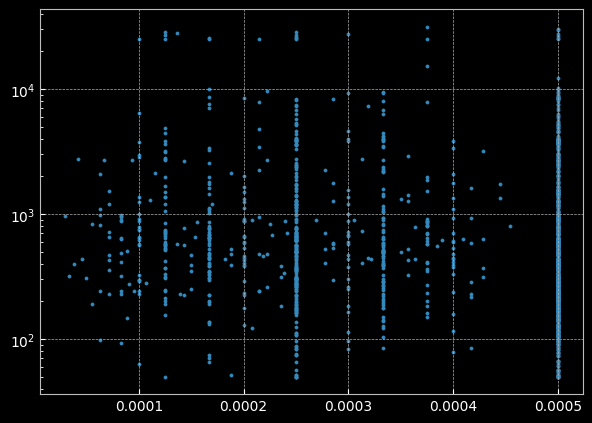

In [ ]:
import matplotlib.pyplot as plt

set_plot_defaults()
plt.figure(figsize=(7,5))
plt.yscale('log')
idx = torch.where(data_rec > 0)[0]
plt.scatter(data_rec[idx], o.pred_ptr[idx], s=5)

In [ ]:
stats.pearsonr(data_rec, o.pred_ptr), stats.spearmanr(data_rec, o.pred_ptr)

(PearsonRResult(statistic=0.01051562736746846, pvalue=0.6383606325600909),
 SignificanceResult(statistic=-0.01098348036247465, pvalue=0.6234944221550949))

# Representation

In [ ]:
args = XCLearningArguments(
    output_dir='/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/ngame_v-3-100_(mapped)LF-WikiSeeAlsoTitles-320K/',
    index_efs=200,
    representation_num_beams=200,
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()
model = DBT008.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', bsz=bsz, tn_targ=10_000, ig_tok=0)

Some weights of DBT008 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['loss_fn.u', 'loss_fn.v']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import OrderedDict

mname = f'{args.output_dir}/model_network.pkl'
m_state_dict, msd = OrderedDict(), torch.load(mname)
for k in msd:
    o = k.split('.')
    if o[0] == 'encoder': m_state_dict['distilbert.'+'.'.join(o[5:])] = msd[k]
model.load_state_dict(m_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['loss_fn.u', 'loss_fn.v'], unexpected_keys=[])

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Reranking

In [ ]:
import torch.nn.functional as F

In [ ]:
data_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset)), dim=1)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
lbl_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset.lbl_dset)), dim=1)

  0%|          | 0/9761 [00:00<?, ?it/s]

In [ ]:
pred_fname = f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/predictions/test_lbl_atrie-hlk_n-bm-50_n-smp-2000_seed-50.pth'
pred = torch.load(pred_fname)

In [ ]:
from tqdm.auto import tqdm
sc,p = [],0
for q,d in tqdm(zip(pred.pred_ptr.cumsum(0),data_repr), total=data_repr.shape[0]):
    sc.append(d@lbl_repr[pred.pred_idx[p:q]].T);p=q
sc = torch.cat(sc)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
o = {
    'pred_idx': pred.pred_idx,
    'pred_ptr': pred.pred_ptr,
    'pred_score': pred.pred_score,
}
o['targ_idx'] = torch.tensor(test_dset.data.data_lbl.indices, dtype=torch.long)
o['targ_ptr'] = torch.tensor([o.getnnz() for o in test_dset.data.data_lbl])

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,13.9,7.666667,5.45,3.18,13.9,12.827645,12.982787,13.47492,8.336685,7.729368,7.953264,8.579562,8.336685,8.370551,8.753456,9.299467,10.30993,11.828644,14.972857,20.270098,24.232263,29.536562


In [ ]:
o['pred_score'] = sc

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,24.25,17.316667,13.54,8.795,24.25,25.335682,26.772436,28.908407,14.99304,17.756563,20.353943,24.711863,14.99304,17.670029,19.543997,21.791258,19.276151,23.778776,35.378377,45.396318,47.681621,48.792787
